
STARTING PINN TRAINING WITH TIMING ANALYSIS

Training Case 1 (Normal, No Infusion)
Gt = 0, Bb = 14.30
Pre-training with Adam optimizer...
Epoch    0 - Total Loss: 664721.250000, ODE Loss: 3135.278809, IC Loss: 6615.859863
Epoch  500 - Total Loss: 0.154420, ODE Loss: 0.152922, IC Loss: 0.000015
Epoch 1000 - Total Loss: 0.084530, ODE Loss: 0.084053, IC Loss: 0.000005
Epoch 1500 - Total Loss: 0.054486, ODE Loss: 0.054282, IC Loss: 0.000002
Epoch 2000 - Total Loss: 0.032324, ODE Loss: 0.032245, IC Loss: 0.000001
Epoch 2500 - Total Loss: 0.017920, ODE Loss: 0.017900, IC Loss: 0.000000
Epoch 3000 - Total Loss: 0.009766, ODE Loss: 0.009765, IC Loss: 0.000000
Epoch 3500 - Total Loss: 0.005674, ODE Loss: 0.005672, IC Loss: 0.000000
Epoch 4000 - Total Loss: 0.003717, ODE Loss: 0.003709, IC Loss: 0.000000
Epoch 4500 - Total Loss: 0.002658, ODE Loss: 0.002647, IC Loss: 0.000000
Epoch 5000 - Total Loss: 0.001945, ODE Loss: 0.001934, IC Loss: 0.000000
Epoch 5500 - Total Loss: 0.001425, ODE Loss: 0.

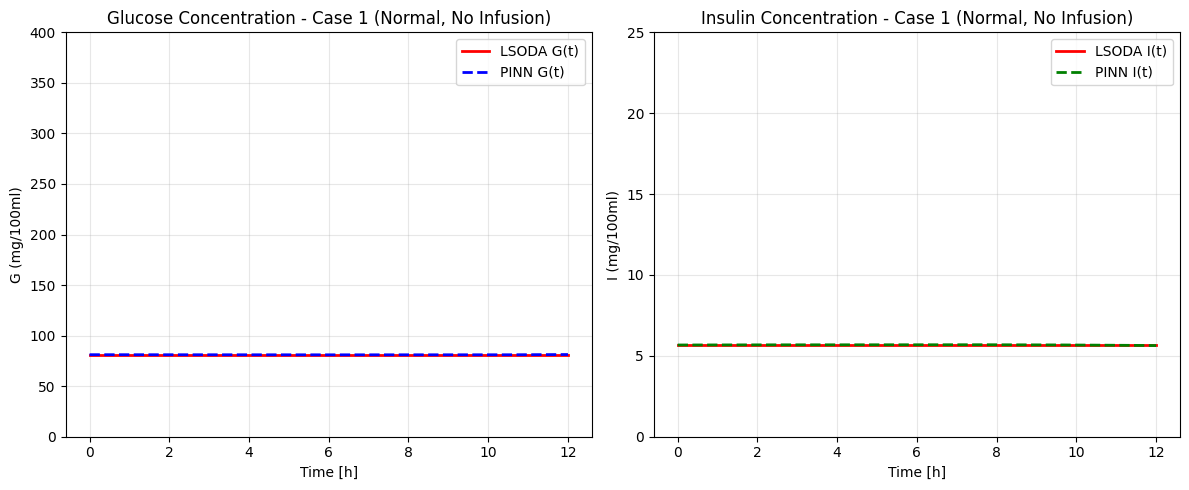

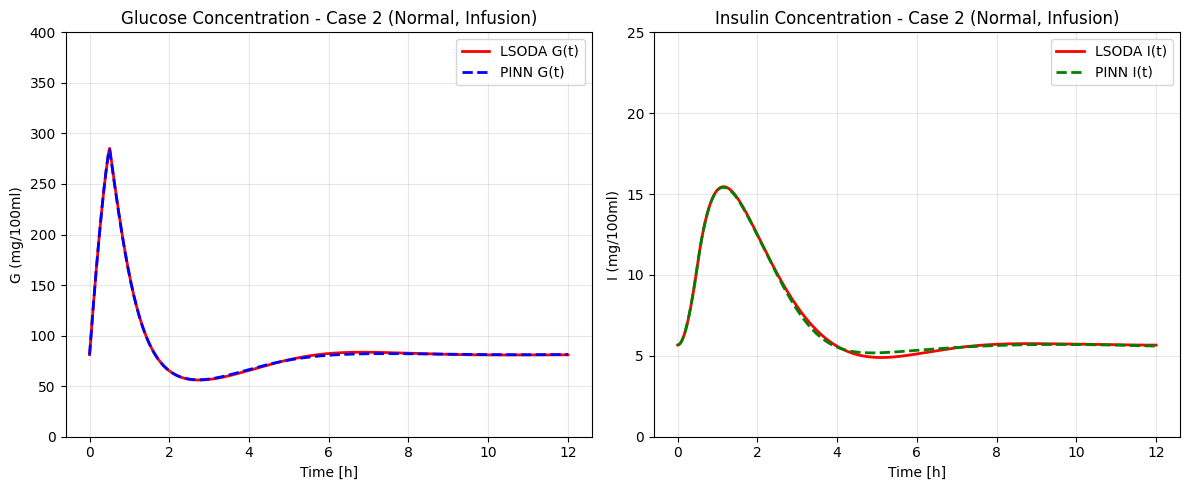

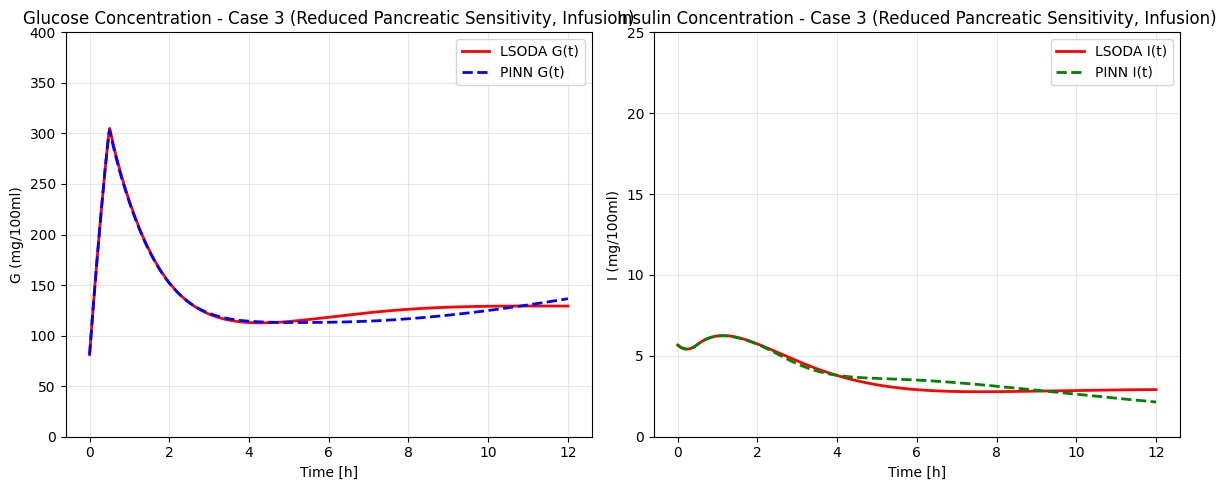

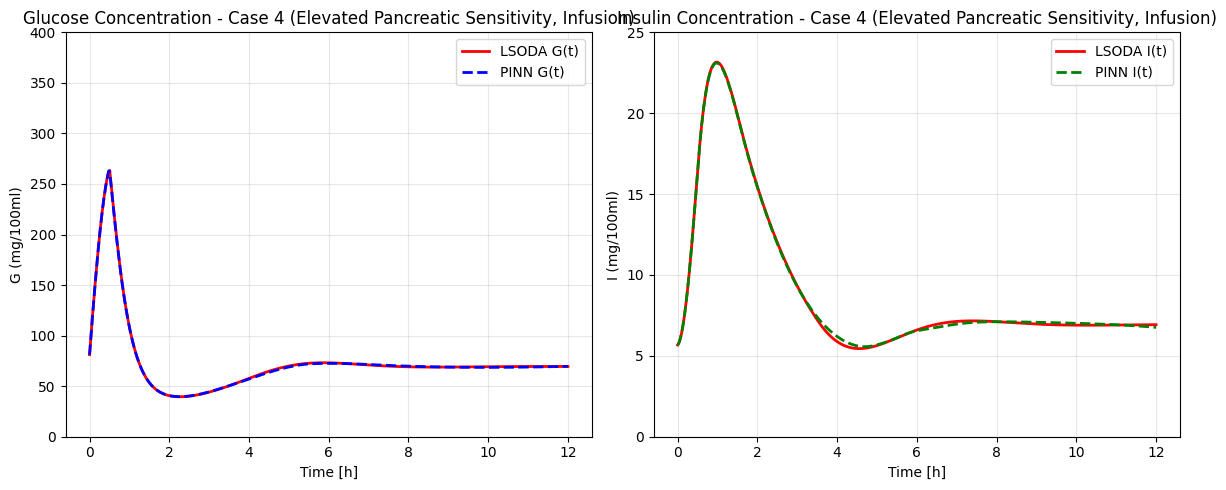


COMPREHENSIVE SUMMARY TABLE
Case   Gt       Bb       Total Loss   ODE Loss     IC Loss      Max G Err    Max I Err    Train Time   Solution Time 
------------------------------------------------------------------------------------------------------------------------
1      0        14.30    0.000565     0.000561     0.000000     0.159271     0.035367     1776.06      0.034580      
2      80000    14.30    0.045627     0.045627     0.000000     1.813004     0.305414     2144.65      0.015177      
3      80000    2.86     0.091897     0.091896     0.000000     9.400795     0.767205     2219.87      0.016386      
4      80000    28.60    0.060491     0.060489     0.000000     1.118231     0.318096     2289.87      0.014870      

DETAILED TIMING ANALYSIS

Per-Case Training Times:
Case                                     Adam (s)     L-BFGS (s)   Total (s)   
--------------------------------------------------------------------------------
Case 1 (Normal, No Infusion)             1772.0

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.optimize
import time

# --- Fixed Parameters ---
Cg = 150
Ci = 150
Q = 8400
Dd = 24.7
Gg = 13.9
Gk = 250
Mu = 72
G0 = 51
Aa = 76

# Initial Conditions
G_init = 81.14
I_init = 5.671

# Case definitions
cases = [
    {"name": "Case 1 (Normal, No Infusion)", "Gt": 0, "Bb": 14.3},
    {"name": "Case 2 (Normal, Infusion)", "Gt": 80000, "Bb": 14.3},
    {"name": "Case 3 (Reduced Pancreatic Sensitivity, Infusion)", "Gt": 80000, "Bb": 0.2 * 14.3},
    {"name": "Case 4 (Elevated Pancreatic Sensitivity, Infusion)", "Gt": 80000, "Bb": 2.0 * 14.3}
]

# Glucose infusion function (piecewise)
def glucose_infusion(t, Gt_val):
    return tf.where(t < 0.5, tf.constant(Gt_val, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32))

# Smooth sigmoid-based switch
def smooth_switch(x, threshold, eps=0.5):
    return tf.sigmoid((threshold - x) / eps)

# --- PINN Model ---
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.d1 = tf.keras.layers.Dense(128, activation='swish')
        self.d2 = tf.keras.layers.Dense(128, activation='swish')
        self.d3 = tf.keras.layers.Dense(128, activation='swish')
        self.d4 = tf.keras.layers.Dense(128, activation='swish')
        self.out = tf.keras.layers.Dense(2, activation=None)

    def call(self, t):
        x = self.d1(t)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        return self.out(x)

# --- Loss function with detailed breakdown ---
def loss_fn_detailed(model, t, Gt_val, Bb_val):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        pred = model(t)
        G = pred[:, 0:1]
        I = pred[:, 1:2]

    # Gradient calls outside the 'with' block
    dG_dt = tape.gradient(G, t)
    dI_dt = tape.gradient(I, t)
    del tape  # Cleanup to avoid memory leaks

    In = glucose_infusion(t, Gt_val)
    sG = smooth_switch(G, Gk)
    sI = smooth_switch(G, G0)

    dG_rhs = (Q + In - Gg * I * G - Dd * G) / Cg
    dG_rhs_alt = (Q + In - Gg * I * G - Dd * G - Mu * (G - Gk)) / Cg
    dG_model = sG * dG_rhs + (1 - sG) * dG_rhs_alt

    dI_rhs = (-Aa * I) / Ci
    dI_rhs_alt = (-Aa * I + Bb_val * (G - G0)) / Ci
    dI_model = sI * dI_rhs + (1 - sI) * dI_rhs_alt

    res_G = dG_dt - dG_model
    res_I = dI_dt - dI_model

    ic_loss_G = tf.square(G[0] - G_init)
    ic_loss_I = tf.square(I[0] - I_init)

    ode_loss = tf.reduce_mean(tf.square(res_G)) + tf.reduce_mean(tf.square(res_I))
    ic_loss = ic_loss_G + ic_loss_I
    total_loss = ode_loss + 100 * ic_loss

    return total_loss, ode_loss, ic_loss

# --- L-BFGS Optimizer Wrapper ---
def get_weights(model):
    return np.concatenate([w.numpy().flatten() for w in model.trainable_variables])

def set_weights(model, flat_weights):
    pointer = 0
    for var in model.trainable_variables:
        shape = var.shape
        size = np.prod(shape)
        var.assign(flat_weights[pointer:pointer+size].reshape(shape))
        pointer += size

def create_loss_and_grad_fn(model, t_train_tensor, Gt_val, Bb_val):
    def loss_and_grad(flat_weights):
        set_weights(model, flat_weights)
        with tf.GradientTape() as tape:
            total_loss, _, _ = loss_fn_detailed(model, t_train_tensor, Gt_val, Bb_val)
        grads = tape.gradient(total_loss, model.trainable_variables)
        grad_flat = np.concatenate([g.numpy().flatten() for g in grads])
        return total_loss.numpy().astype(np.float64), grad_flat.astype(np.float64)
    return loss_and_grad

# --- LSODA reference solution ---
def ode_rhs(t, y, Gt_val, Bb_val):
    G, I = y
    In = Gt_val if t < 0.5 else 0
    if G < Gk:
        dGdt = (Q + In - Gg * I * G - Dd * G) / Cg
    else:
        dGdt = (Q + In - Gg * I * G - Dd * G - Mu * (G - Gk)) / Cg

    if G < G0:
        dIdt = (-Aa * I) / Ci
    else:
        dIdt = (-Aa * I + Bb_val * (G - G0)) / Ci

    return [dGdt, dIdt]

# --- Time domain ---
t_dense = np.linspace(0, 2, 200)
t_rest = np.linspace(2, 12, 100)
t_all = np.concatenate([t_dense, t_rest])
t_train_tensor = tf.convert_to_tensor(t_all[:, None], dtype=tf.float32)

t_test = np.linspace(0, 12, 500)[:, None].astype(np.float32)

# Storage for results
results = []

# Initialize timing variables
total_training_time = 0
total_ode_solution_time = 0

print(f"\n{'='*80}")
print("STARTING PINN TRAINING WITH TIMING ANALYSIS")
print(f"{'='*80}")

# Process each case
for case_idx, case in enumerate(cases):
    print(f"\n{'='*60}")
    print(f"Training {case['name']}")
    print(f"Gt = {case['Gt']}, Bb = {case['Bb']:.2f}")
    print(f"{'='*60}")

    # Start timing for this case
    case_start_time = time.time()

    # Create and train model for this case
    model = PINN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    # Pre-train with Adam
    print("Pre-training with Adam optimizer...")
    adam_start_time = time.time()

    for epoch in range(10000):
        with tf.GradientTape() as tape:
            total_loss, ode_loss, ic_loss = loss_fn_detailed(model, t_train_tensor, case['Gt'], case['Bb'])
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 500 == 0:
            print(f"Epoch {epoch:4d} - Total Loss: {total_loss.numpy().item():.6f}, "
                  f"ODE Loss: {ode_loss.numpy().item():.6f}, IC Loss: {ic_loss.numpy().item():.6f}")

    adam_end_time = time.time()
    adam_training_time = adam_end_time - adam_start_time
    print(f"Adam training completed in {adam_training_time:.2f} seconds")

    # Fine-tune with L-BFGS
    print("Fine-tuning with L-BFGS optimizer...")
    lbfgs_start_time = time.time()

    loss_and_grad_fn = create_loss_and_grad_fn(model, t_train_tensor, case['Gt'], case['Bb'])
    init_weights = get_weights(model)

    result = scipy.optimize.minimize(
        fun=loss_and_grad_fn,
        x0=init_weights,
        jac=True,
        method='L-BFGS-B',
        options={'maxiter': 50000, 'maxfun': 50000, 'maxcor': 50}
    )
    set_weights(model, result.x)

    lbfgs_end_time = time.time()
    lbfgs_training_time = lbfgs_end_time - lbfgs_start_time
    print(f"L-BFGS training completed in {lbfgs_training_time:.2f} seconds")

    # Calculate total training time for this case
    case_training_time = time.time() - case_start_time
    total_training_time += case_training_time

    # Final loss calculation
    total_loss, ode_loss, ic_loss = loss_fn_detailed(model, t_train_tensor, case['Gt'], case['Bb'])
    print(f"Final - Total Loss: {total_loss.numpy().item():.6f}, "
          f"ODE Loss: {ode_loss.numpy().item():.6f}, IC Loss: {ic_loss.numpy().item():.6f}")

    # Time the PINN prediction (ODE solution)
    print("Getting PINN predictions...")
    pinn_start_time = time.time()
    G_pred, I_pred = model(tf.convert_to_tensor(t_test)).numpy().T
    pinn_end_time = time.time()
    pinn_solution_time = pinn_end_time - pinn_start_time
    total_ode_solution_time += pinn_solution_time

    # Time the LSODA solution for comparison
    print("Getting LSODA reference solution...")
    lsoda_start_time = time.time()
    sol = solve_ivp(
        lambda t, y: ode_rhs(t, y, case['Gt'], case['Bb']),
        [0, 12],
        [G_init, I_init],
        t_eval=t_test[:, 0],
        rtol=1e-6,
        atol=1e-6
    )
    G_true, I_true = sol.y
    lsoda_end_time = time.time()
    lsoda_solution_time = lsoda_end_time - lsoda_start_time

    # Calculate errors
    G_error = np.abs(G_pred - G_true)
    I_error = np.abs(I_pred - I_true)

    max_G_error = np.max(G_error)
    min_G_error = np.min(G_error)
    max_I_error = np.max(I_error)
    min_I_error = np.min(I_error)

    print(f"Glucose Error - Max: {max_G_error:.6f}, Min: {min_G_error:.6f}")
    print(f"Insulin Error - Max: {max_I_error:.6f}, Min: {min_I_error:.6f}")

    # Print timing results for this case
    print(f"\n--- TIMING RESULTS FOR {case['name']} ---")
    print(f"Adam Training Time:    {adam_training_time:.2f} seconds")
    print(f"L-BFGS Training Time:  {lbfgs_training_time:.2f} seconds")
    print(f"Total Training Time:   {case_training_time:.2f} seconds")
    print(f"PINN Solution Time:    {pinn_solution_time:.6f} seconds")
    print(f"LSODA Solution Time:   {lsoda_solution_time:.6f} seconds")
    print(f"Speedup Factor:        {lsoda_solution_time/pinn_solution_time:.2f}x")

    # Store results
    results.append({
        'case': case,
        'model': model,
        't_test': t_test[:, 0],
        'G_pred': G_pred,
        'I_pred': I_pred,
        'G_true': G_true,
        'I_true': I_true,
        'G_error': G_error,
        'I_error': I_error,
        'max_G_error': max_G_error,
        'min_G_error': min_G_error,
        'max_I_error': max_I_error,
        'min_I_error': min_I_error,
        'final_total_loss': total_loss.numpy().item(),
        'final_ode_loss': ode_loss.numpy().item(),
        'final_ic_loss': ic_loss.numpy().item(),
        'adam_training_time': adam_training_time,
        'lbfgs_training_time': lbfgs_training_time,
        'total_training_time': case_training_time,
        'pinn_solution_time': pinn_solution_time,
        'lsoda_solution_time': lsoda_solution_time
    })

# --- Plotting ---
print(f"\n{'='*60}")
print("Generating plots...")
print(f"{'='*60}")

# Create plots for each case
for i, result in enumerate(results):
    case_name = result['case']['name']

    # Plot Glucose
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(result['t_test'], result['G_true'], label="LSODA G(t)", color="red", linewidth=2)
    plt.plot(result['t_test'], result['G_pred'], '--', label="PINN G(t)", color="blue", linewidth=2)
    plt.title(f"Glucose Concentration - {case_name}")
    plt.xlabel("Time [h]")
    plt.ylabel("G (mg/100ml)")
    plt.ylim(0, 400)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Insulin
    plt.subplot(1, 2, 2)
    plt.plot(result['t_test'], result['I_true'], label="LSODA I(t)", color="red", linewidth=2)
    plt.plot(result['t_test'], result['I_pred'], '--', label="PINN I(t)", color="green", linewidth=2)
    plt.title(f"Insulin Concentration - {case_name}")
    plt.xlabel("Time [h]")
    plt.ylabel("I (mg/100ml)")
    plt.ylim(0, 25)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Summary table with timing information
print(f"\n{'='*120}")
print("COMPREHENSIVE SUMMARY TABLE")
print(f"{'='*120}")
print(f"{'Case':<6} {'Gt':<8} {'Bb':<8} {'Total Loss':<12} {'ODE Loss':<12} {'IC Loss':<12} {'Max G Err':<12} {'Max I Err':<12} {'Train Time':<12} {'Solution Time':<14}")
print(f"{'-'*120}")
for i, result in enumerate(results):
    case_num = i + 1
    gt = result['case']['Gt']
    bb = result['case']['Bb']
    total_loss = result['final_total_loss']
    ode_loss = result['final_ode_loss']
    ic_loss = result['final_ic_loss']
    max_g_err = result['max_G_error']
    max_i_err = result['max_I_error']
    train_time = result['total_training_time']
    solution_time = result['pinn_solution_time']

    print(f"{case_num:<6} {gt:<8} {bb:<8.2f} {total_loss:<12.6f} {ode_loss:<12.6f} {ic_loss:<12.6f} {max_g_err:<12.6f} {max_i_err:<12.6f} {train_time:<12.2f} {solution_time:<14.6f}")

print(f"{'='*120}")

# Detailed timing summary
print(f"\n{'='*80}")
print("DETAILED TIMING ANALYSIS")
print(f"{'='*80}")

print(f"\nPer-Case Training Times:")
print(f"{'Case':<40} {'Adam (s)':<12} {'L-BFGS (s)':<12} {'Total (s)':<12}")
print(f"{'-'*80}")
for i, result in enumerate(results):
    case_name = result['case']['name']
    adam_time = result['adam_training_time']
    lbfgs_time = result['lbfgs_training_time']
    total_time = result['total_training_time']
    print(f"{case_name:<40} {adam_time:<12.2f} {lbfgs_time:<12.2f} {total_time:<12.2f}")

print(f"\nPer-Case Solution Times:")
print(f"{'Case':<40} {'PINN (s)':<12} {'LSODA (s)':<12} {'Speedup':<12}")
print(f"{'-'*80}")
for i, result in enumerate(results):
    case_name = result['case']['name']
    pinn_time = result['pinn_solution_time']
    lsoda_time = result['lsoda_solution_time']
    speedup = lsoda_time / pinn_time
    print(f"{case_name:<40} {pinn_time:<12.6f} {lsoda_time:<12.6f} {speedup:<12.2f}x")

print(f"\n{'='*80}")
print("OVERALL TIMING SUMMARY")
print(f"{'='*80}")
print(f"Total Training Time (All Cases):     {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
print(f"Total PINN Solution Time (All Cases): {total_ode_solution_time:.6f} seconds")
print(f"Average Training Time per Case:       {total_training_time/len(cases):.2f} seconds")
print(f"Average Solution Time per Case:       {total_ode_solution_time/len(cases):.6f} seconds")

# Calculate total LSODA time for comparison
total_lsoda_time = sum(result['lsoda_solution_time'] for result in results)
print(f"Total LSODA Solution Time (All Cases): {total_lsoda_time:.6f} seconds")
print(f"Overall Solution Speedup:              {total_lsoda_time/total_ode_solution_time:.2f}x")

print(f"{'='*80}")
print("Training and analysis completed for all cases!")
print(f"{'='*80}")